In [1]:
from google.cloud import storage
import pandas as pd
import numpy as np
from io import StringIO
import matplotlib
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import torch
from U_FNOB import *
from lploss import *

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

torch.manual_seed(0)
np.random.seed(0)

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import gcsfs
import pyarrow.parquet as pq
def read_parquet(gs_directory_path, to_pandas=True):
    """
    Reads multiple (partitioned) parquet files from a GS directory
    e.g. 'gs://<bucket>/<directory>' (without ending /)
    """
    gs = gcsfs.GCSFileSystem()
    arrow_df = pq.ParquetDataset(gs_directory_path, filesystem=gs)
    if to_pandas:
        return arrow_df.read_pandas().to_pandas()
    return arrow_df

 # Connect to GCP

In [3]:
bucket_name = "us-digitaltwiner-pub-features"
storage_client = storage.Client()
bucket = storage_client.get_bucket(bucket_name)

blob = bucket.get_blob("srs_farea_ensemble_simulations_dataset/sampled_params_succ_status.csv")
params_string = blob.download_as_text()
params_string = StringIO(params_string)
sim_parameters = pd.read_csv(params_string, index_col=0)
sim_parameters = sim_parameters.rename({"@serial_number@": "sim_id","@sim_path@": "path", "@Perm@": "permeability","@Por@": "porosity", "@alpha@": "alpha","@sr@":"residual water content","@m@":"m", "@Rech_hist@": "recharge history","@Rech_mid@": "recharge mid-century", "@Rech_late@": "recharge late-century", "@seepage@": "seepage","@seepage_conc@":"seepage concentration","@cap_rate@":"cap rate",  "@successful@":"successful"}, axis=1)
sim_parameters.index = sim_parameters["sim_id"]
sim_parameters.drop("sim_id", axis=1, inplace=True)
sim_parameters['path'] = sim_parameters['path'].str.replace(r'/global/scratch/users/satyarth/Projects/ensemble_simulation_runs/', '')
sim_parameters = sim_parameters[sim_parameters["successful"]==True].drop("successful", axis=1)
# for recharge combination
order = ['path','permeability','porosity','alpha','residual water content','m','recharge history','seepage','seepage concentration','cap rate', 'recharge mid-century','recharge late-century']
sim_parameters = sim_parameters[order]
# sim_parameters = sim_parameters[np.append(np.append(sim_parameters.columns[:-3],sim_parameters.columns[-1]),sim_parameters.columns[-3:-1])]

In [4]:
sim_parameters

,path,permeability,porosity,alpha,residual water content,m,recharge history,seepage,seepage concentration,cap rate,recharge mid-century,recharge late-century
sim_id,,,,,,,,,,,,
1,ensemble_simulation_run4_fdl2d_allvars/sim1,6.352946e-12,0.369369,0.000444,0.176459,0.434981,0.000019,0.000112,9.982423e-09,4.191123e-09,0.000003,0.000010
2,ensemble_simulation_run4_fdl2d_allvars/sim2,4.487115e-12,0.441803,0.000346,0.196802,0.453387,0.000011,0.000169,6.316405e-09,7.432788e-09,0.000007,0.000020
4,ensemble_simulation_run4_fdl2d_allvars/sim4,7.017365e-12,0.390180,0.000428,0.148700,0.454111,0.000009,0.000160,5.073743e-09,2.808730e-09,0.000015,0.000005
5,ensemble_simulation_run4_fdl2d_allvars/sim5,4.918813e-12,0.314238,0.000340,0.145077,0.427412,0.000005,0.000101,1.985429e-09,4.474905e-09,0.000010,0.000015
6,ensemble_simulation_run4_fdl2d_allvars/sim6,6.143176e-12,0.369789,0.000452,0.160960,0.598896,0.000009,0.000213,3.243729e-09,7.534759e-09,0.000009,0.000008
...,...,...,...,...,...,...,...,...,...,...,...,...
994,ensemble_simulation_run4_fdl2d_allvars/sim994,3.746184e-12,0.336327,0.000372,0.171081,0.518314,0.000009,0.000154,3.794421e-09,4.860552e-09,0.000002,0.000009
995,ensemble_simulation_run4_fdl2d_allvars/sim995,5.497041e-12,0.392884,0.000440,0.186012,0.473534,0.000015,0.000151,4.991011e-09,5.811999e-09,0.000015,0.000015
996,ensemble_simulation_run4_fdl2d_allvars/sim996,5.924298e-12,0.331065,0.000477,0.166014,0.531001,0.000018,0.000108,2.273184e-09,8.643174e-09,0.000012,0.000013


 ## Inputs

In [5]:
sim_path = sim_parameters.iloc[0]['path']

In [6]:
sim_path = sim_parameters.iloc[0]['path']
extra_path = "processed_data"
file_name = "1954y_0000000090c.parq"
sample_file = read_parquet(bucket_name + "/" + sim_path + "/" + extra_path + "/" + file_name) # sample file to get meta data like simulation resolution etc

In [7]:
input_min = np.min(np.array(sim_parameters.values[:,1:sim_parameters.shape[1]],dtype = 'float64') ,axis = 0)
input_max = np.max(np.array(sim_parameters.values[:,1:sim_parameters.shape[1]],dtype = 'float64') ,axis = 0)

In [9]:
output_vars = list(sample_file.columns[2:])
no = len(output_vars) #number of outputs

# Change data from point to grid
xmin = math.floor(sample_file.x.min())
zmin = math.floor(sample_file.z.min())
xmax = math.ceil(sample_file.x.max())
zmax = math.ceil(sample_file.z.max())

# sx, sz: scale to set resolution of the grid 
sx = 10
sz = 2.5

# Recalculate the max value according to the scale
xmax = math.ceil((xmax-xmin)/sx)*sx+xmin
zmax = math.ceil((zmax-zmin)/sz)*sz+zmin

# nx, ny: num of each dimension in this grid
nx = np.int((xmax-xmin)/sx) # simulation pixels x
nz = np.int((zmax-zmin)/sz) # simulation pixels y


# num of sample
sim_id = sim_parameters.index

ns = sim_parameters.shape[0]
nc = sim_parameters.shape[1]-1

# we have three recharge columns, so we should -2 for nc
nc = nc - 3

# time steps
time_steps = np.arange(1955,2105,5) # 30 time snapshots
nt = time_steps.shape[0] # number of time steps

# time_interval
time_interval = np.array([2020,2060])
time_indicator = (time_steps>time_interval[1])*1+(time_steps>time_interval[0])*1


# time_interval 2 -> seepage, cap
time_interval2 = np.array([1988])
time_indicator2 = (time_steps>time_interval2[0])*1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

In [10]:
print("Number of simulations: {}".format(ns))
print("Number of input paramters: {} ({})".format(nc, list(sim_parameters.columns[1:])))
print("Number of outputs paramters: {} ({})".format(no, output_vars))
print("Simulation output shape: ({}, {})".format(nz, nx))
print("Number of time steps: {}".format(nt))
print("---------------------------------------")
print("Expected input shape: [{}, {}, {}, {}, {}]".format(ns, nz, nx, nt, nc+3)) # +3 is (x_loc, y_loc, time)

Number of simulations: 664
Number of input paramters: 8 (['permeability', 'porosity', 'alpha', 'residual water content', 'm', 'recharge history', 'seepage', 'seepage concentration', 'cap rate', 'recharge mid-century', 'recharge late-century'])
Number of outputs paramters: 7 (['darcy_velocity.cell.0', 'darcy_velocity.cell.1', 'hydraulic_head.cell.0', 'pressure.cell.0', 'saturation_liquid.cell.0', 'total_component_concentration.cell.Tritium conc', 'water_content.cell.0'])
Simulation output shape: (24, 257)
Number of time steps: 30
---------------------------------------
Expected input shape: [664, 24, 257, 30, 11]


 ## Outputs

In [11]:
def point_to_grid(data, xmin, zmin, sx, sz, nx, nz):
    data_grid = np.zeros((nz, nx))
    data_grid[:] = np.nan
    data_point_rescale = np.array(np.floor((data.values[:,:2]-[xmin, zmin])/[sx, sz]), dtype = 'int64')
    data_grid[data_point_rescale[:,1],data_point_rescale[:,0]] = data.values[:,2]
    return data_grid

In [12]:
path = "gs://" + bucket_name + "/srs_farea_ensemble_simulations_dataset/"
output_all = np.zeros((ns, nz, nx, nt, no))

for nsim, id in enumerate(tqdm(sim_id)):
    if(nsim==2):
        break
    folder_name_list = [str(blob).split(', ')[1].split('/')[-1] for blob in storage_client.list_blobs('us-digitaltwiner-pub-features', 
                                                                                              prefix='srs_farea_ensemble_simulations_dataset/sim'+str(id)+'/processed_data/')]
    folder_name_list_array =  np.array([folder_name.split('_') for folder_name in folder_name_list])
    for time_idx, time in enumerate(time_steps):
        file_name = np.array(folder_name_list)[np.where(folder_name_list_array[:,0]==str(np.int(time))+'y')[0][-1]]
        test_data = read_parquet(path+'sim'+str(id)+'/processed_data/'+file_name, to_pandas=True)
        for out_index in range(0, no):
            output_all[nsim,:,:,time_idx, out_index] = point_to_grid(test_data.iloc[:,[0,1,out_index+2]], xmin, zmin, sx, sz, nx, nz)

  0%|          | 0/664 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
  0%|          | 2/664 [01:49<10:04:41, 54.81s/it]


## Calculate elevation

In [13]:
dem_z = np.array([np.max(test_data['z'][test_data['x']==x_value]) for x_value in np.unique(test_data['x'])])
DEM_array_grid = np.zeros(nx)
DEM_array_grid[np.array(np.floor((np.unique(test_data['x'])-xmin)/sx) ,dtype = 'int64')]= dem_z
DEM = (DEM_array_grid-zmin)/(sz*nz)

## Calculate layers indicator

In [14]:
x_location = np.unique(test_data['x'])
test_data['type'] = np.zeros(len(test_data))
layers_idx = np.hstack([np.zeros(3*4),np.zeros(5*4)+1,np.zeros(4*4)+2])

types = np.zeros(len(test_data)) # layer indicator

for x_value in x_location:
    types[test_data[test_data['x']==x_value]['z'].index[np.argsort(test_data[test_data['x']==x_value]['z'])]] = layers_idx

test_data['type'] = types
layer_indicator = point_to_grid(test_data[['x','z', 'type']], xmin, zmin, sx, sz, nx, nz)

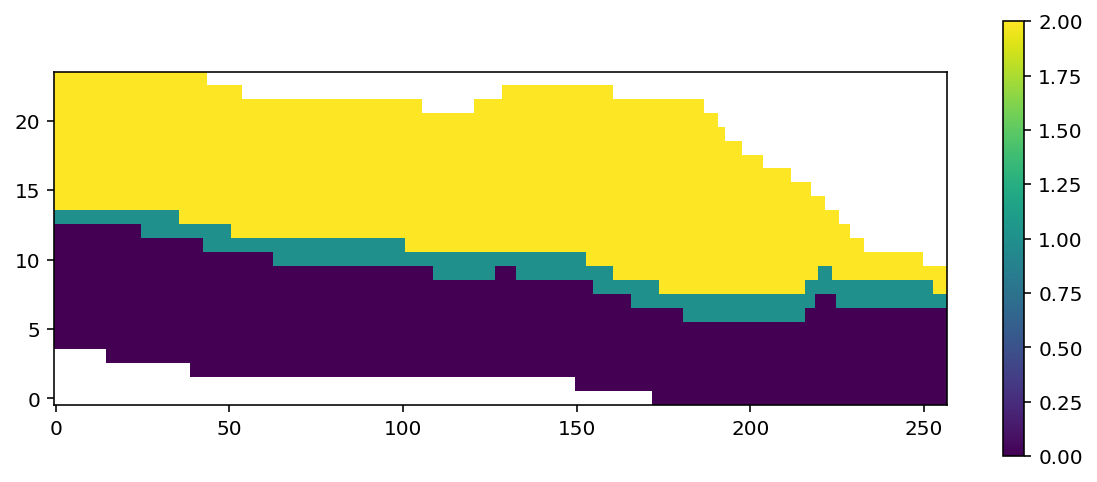

In [15]:
plt.figure(figsize = [10,4])
plt.imshow(layer_indicator,origin = 'lower',aspect = 4)
plt.colorbar()

In [16]:
# top layer
top_layer = np.zeros((nz,nx))
top_layer[:] = np.nan
top_layer[np.array([np.max(np.where(~np.isnan(layer_indicator[5:,i]))[0]+5) for i in range(nx)],dtype = 'int64'),np.arange(nx)] = 1
#top_layer[np.array([np.max(np.where(~np.isnan(layer_indicator[5:,i]))[0]+5)-1 for i in range(nx)],dtype = 'int64'),np.arange(nx)] = 1

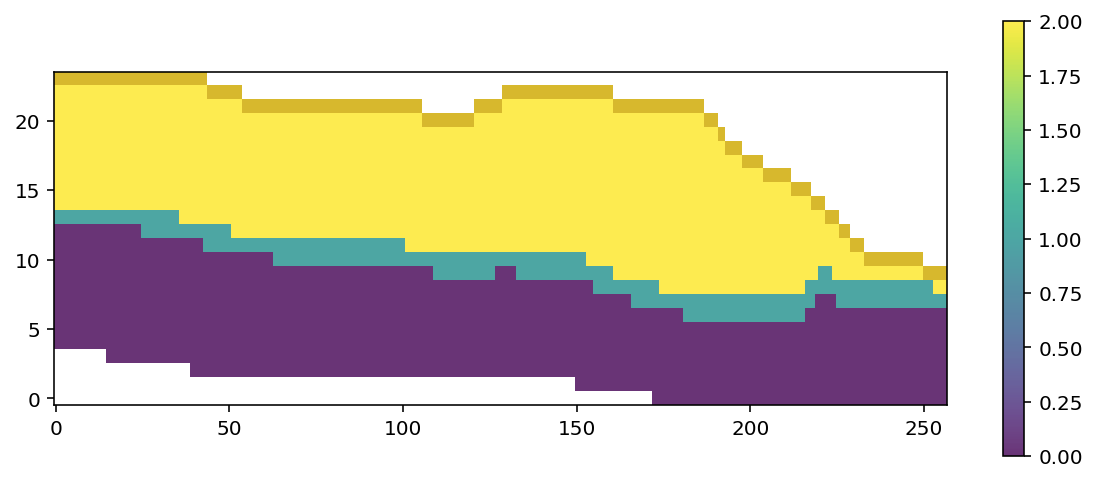

In [17]:
plt.figure(figsize = [10,4])
plt.imshow(top_layer,origin = 'lower',aspect = 4)
plt.imshow(layer_indicator,origin = 'lower',aspect = 4,alpha = 0.8)

plt.colorbar()

In [18]:
# cap region
cap_points = np.array([[1614.61, 86.0535],[1849.67, 84.5525]])
cap_points_rescale = np.array(np.floor((cap_points-[xmin, zmin])/[sx, sz]), dtype = 'int64')

In [19]:
layer_indicator2 = np.zeros((nz,nx))
layer_indicator2[:,cap_points_rescale[0,0]:cap_points_rescale[1,0]] = 1
layer_indicator2[np.isnan(layer_indicator)] = np.nan
layer_indicator2[(layer_indicator)<2] = 0

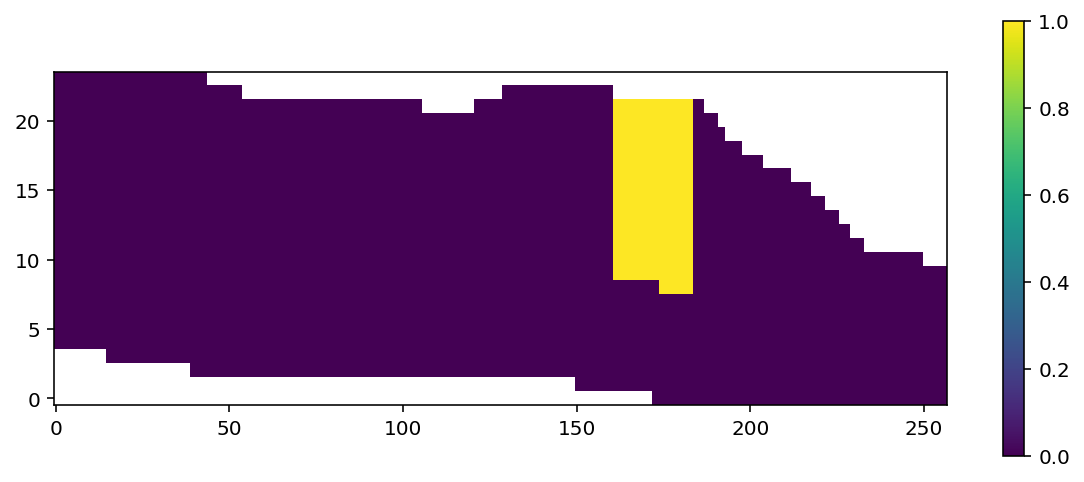

In [20]:
#plt.plot(cap_points_rescale[:,0],cap_points_rescale[:,1],)plt.figure(figsize = [10,4])
plt.figure(figsize = [10,4])
plt.imshow(layer_indicator2,origin = 'lower',aspect = 4)
plt.colorbar()

## Broadcast inputs

In [21]:
input_array = np.array(sim_parameters.values[:,1:sim_parameters.shape[1]],dtype = 'float64')
input_names = np.array(sim_parameters.columns[1:])

In [22]:
# broadcast input to fields
input_array_broadcast = np.expand_dims(input_array[:,:-3], axis = [1,2,3]) # recharn
input_array_broadcast = np.ones([ns,1,1,nt,nc])*input_array_broadcast

# Temporal recharge
input_array_broadcast[:,0,0,time_indicator == 1,5] = input_array[:,-2:-1]
input_array_broadcast[:,0,0,time_indicator == 2,5] = input_array[:,-1:]

# Temporal seepage/cap rate
seepage_idx = np.where(input_names =='seepage')[0][0]
input_array_broadcast[:,0,0,time_indicator2 == 1,seepage_idx] = input_array[:,-3:-2]

input_array_broadcast = np.ones([ns,nz,nx,nt,nc])*input_array_broadcast
input_array_broadcast[:,(layer_indicator!=2),:,5] = 0
input_array_broadcast[:,(top_layer!=1),:,5] = 0
input_array_broadcast[:,(layer_indicator2!=1),:,seepage_idx] = 0
input_array_broadcast[:,(top_layer!=1),:,seepage_idx] = 0
                                                                 
seepage_conc_idx = np.where(input_names =='seepage concentration')[0][0]
input_array_broadcast[:,(layer_indicator2!=1),:,seepage_conc_idx] = 0
input_array_broadcast[:,(top_layer!=1),:,seepage_conc_idx] = 0
                                                                 
input_names[seepage_idx] = 'seepage/caprate'
input_min[seepage_idx] = input_min[-3]

In [23]:
# add location parameters

location_x = np.ones([nz,nx])*np.arange(nx)/nx
location_z = np.ones([nz,nx])*(np.arange(nz)/nz).reshape(nz,-1)

location_z = location_z-DEM+np.max(DEM)

location_x = np.expand_dims(location_x, axis = [0,3,4])
location_z = np.expand_dims(location_z, axis = [0,3,4])

location_t = (time_steps-1950)/150
location_t = np.expand_dims(location_t, axis = [0,1,2,4])


input_location_array = np.ones([ns,nz,nx,nt,3])
input_location_array[:,:,:,:,0:1] = location_x
input_location_array[:,:,:,:,1:2] = location_z
input_location_array[:,:,:,:,2:3] = location_t

input_file = np.concatenate((input_array_broadcast,input_location_array),axis = 4)

print("Input file name: 'input_file' \nInput shape: {}".format(input_file.shape))

Input file name: 'input_file' 
Input shape: (664, 24, 257, 30, 11)


## Make layered subsurface properties

In [24]:
layered_properties = pd.DataFrame(np.array([[5.0e-12,0.39,5.1e-05,0.41,0.5],[1.98e-14,0.39,5.1e-05,0.39,0.5]]),
                                  columns = ['permeability', 'porosity', 'alpha', 'residual water content', 'm'])

In [25]:
for para in layered_properties.columns:
    input_channel_idx = (np.where(para==sim_parameters.columns[1:]))[0][0]
    input_file[:,(layer_indicator==0),:,input_channel_idx:(input_channel_idx+1)] = layered_properties[para][0]
    input_file[:,(layer_indicator==1),:,input_channel_idx:(input_channel_idx+1)] = layered_properties[para][1]
    
input_file[:,np.isnan(layer_indicator),:,:] = np.nan

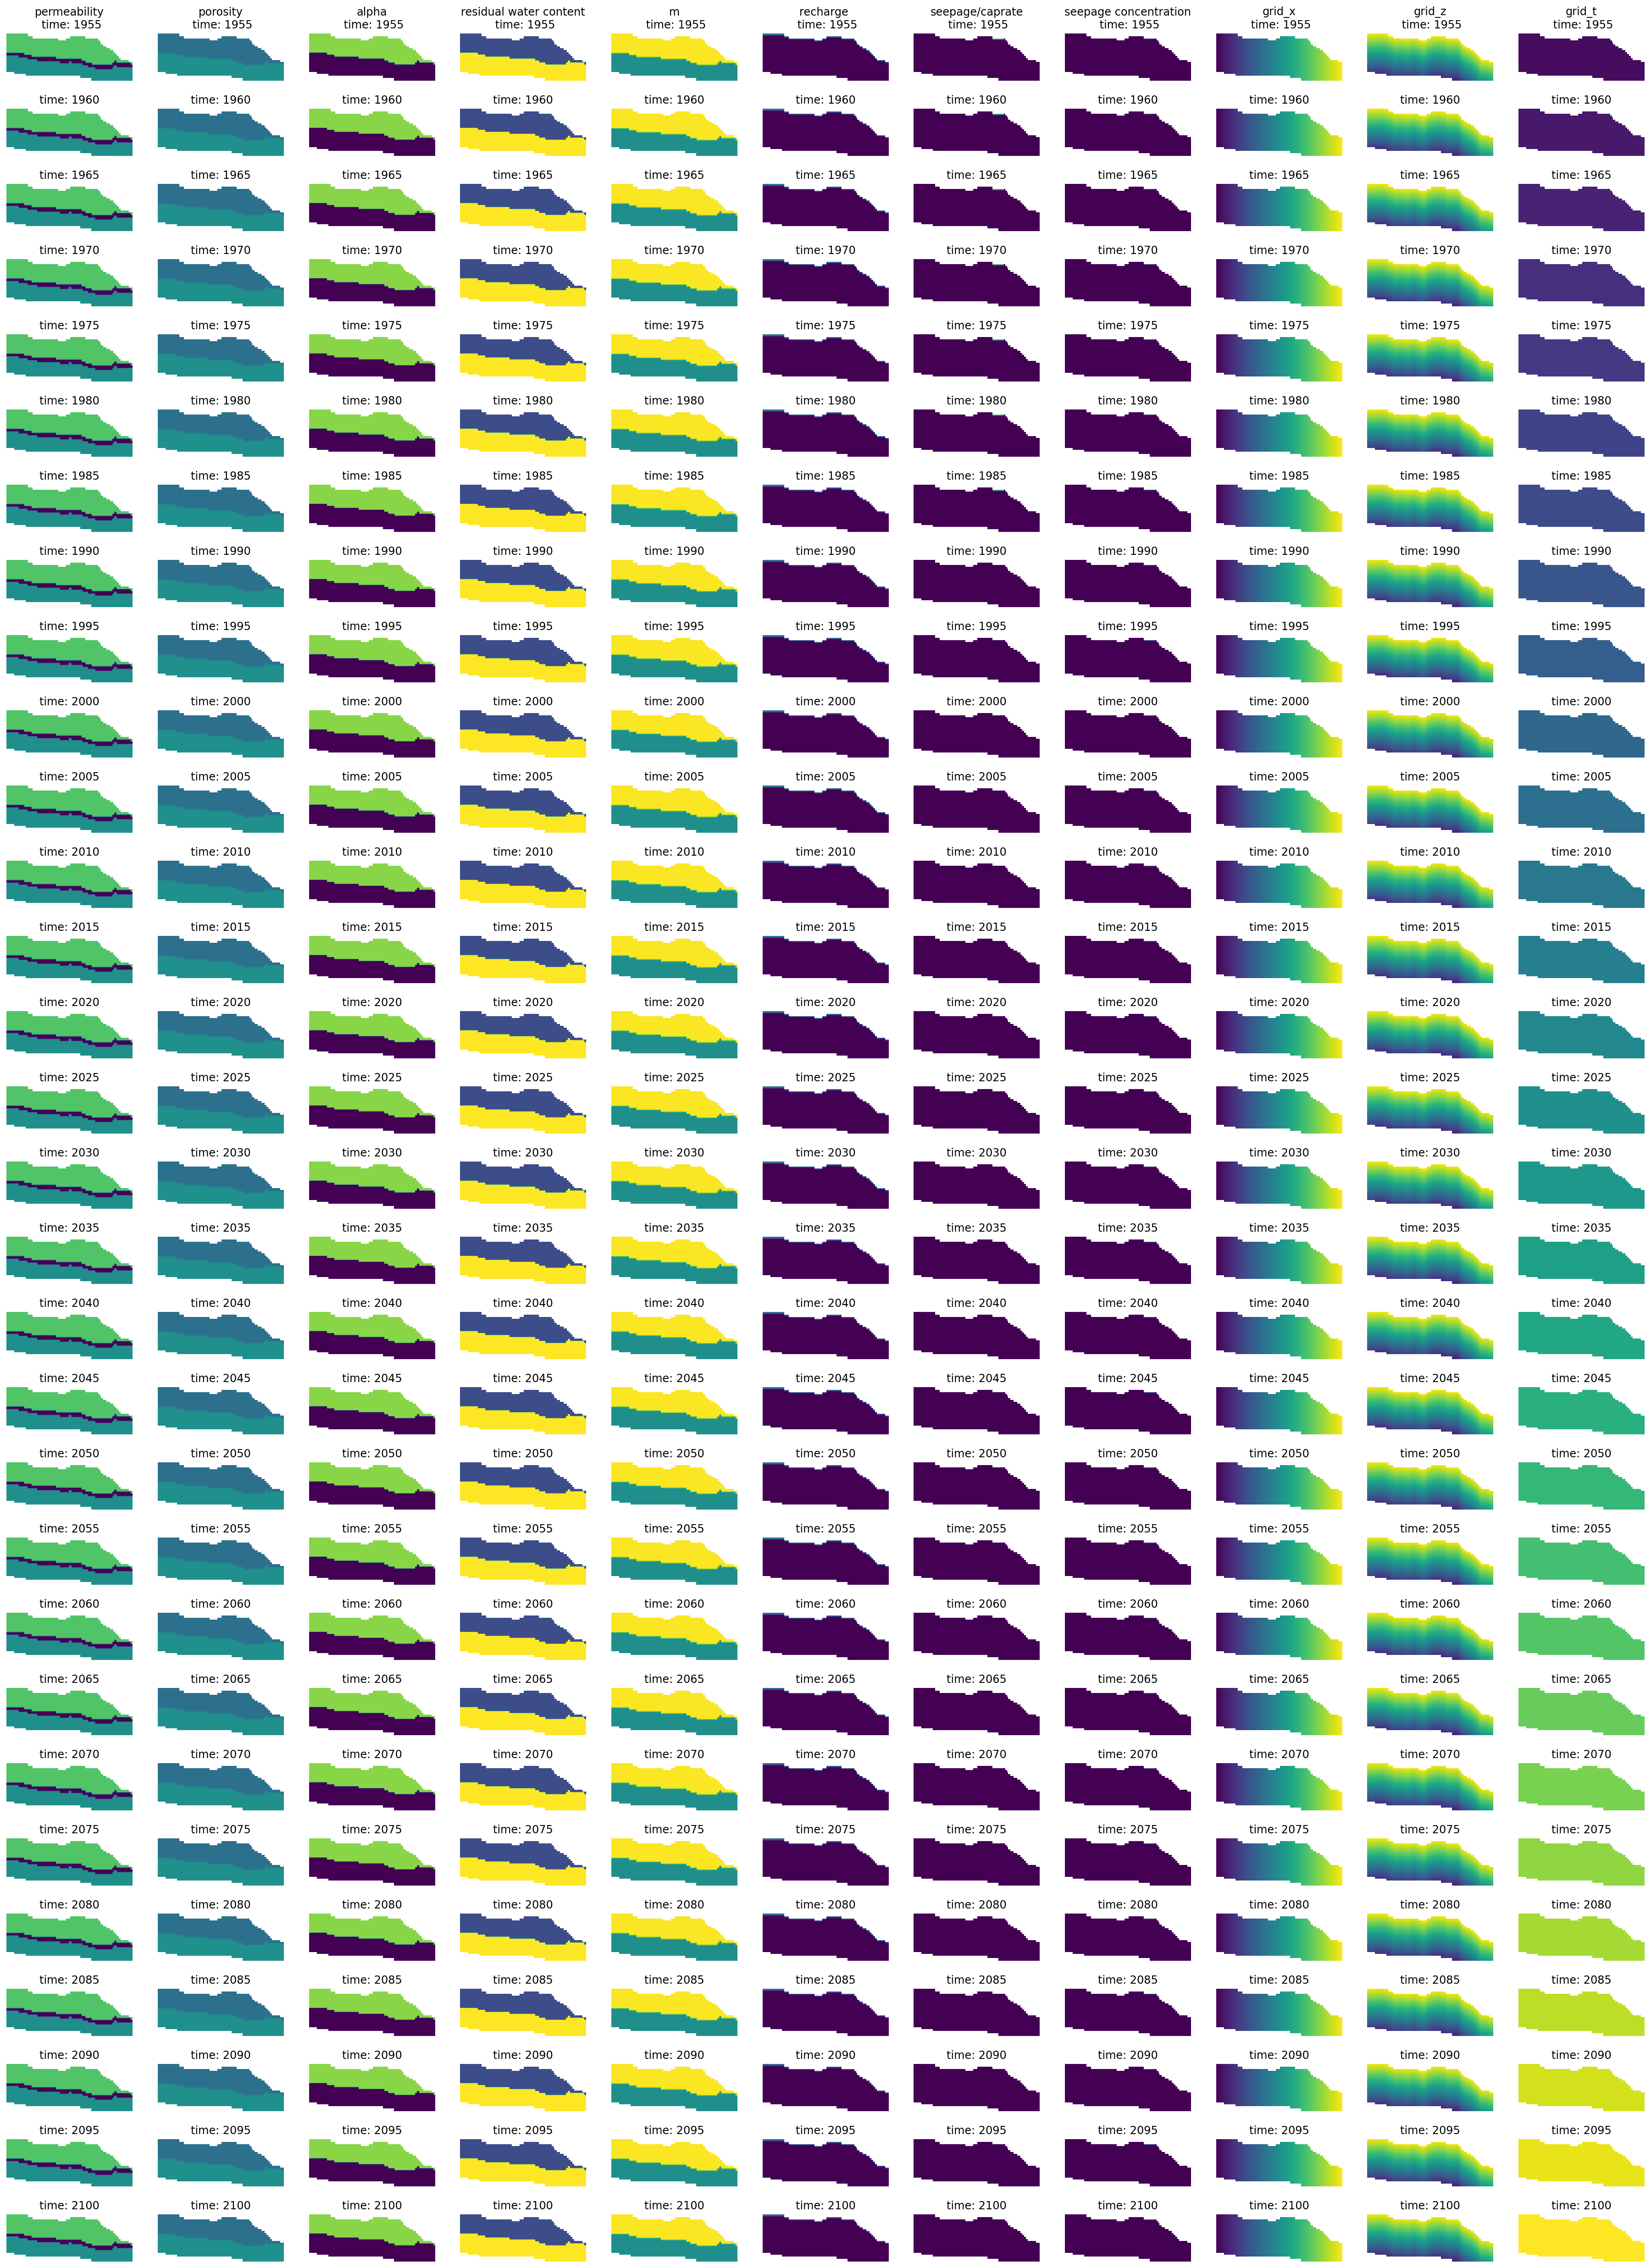

In [28]:
# input visualization
plt.figure(figsize = [32,45])
num_realization = 4

new_name = ['grid_x','grid_z','grid_t']
for t in np.arange(nt):
    for c in np.arange(input_file.shape[-1]):
        ax = plt.subplot(nt, nc+3, t*input_file.shape[-1]+c+1)
        if c < nc: 
            plt.imshow(input_file[num_realization,:,:,t,c],vmin = input_min[c],vmax = input_max[c],origin = 'lower',aspect = 4)
            if t < 1:
                if c == 5:
                    plt.title('recharge \n time: '+str(int(time_steps[t])))
                else:
                    plt.title(str(input_names[c])+'\n time: '+str(int(time_steps[t])))
            else:
                plt.title('time: '+str(int(time_steps[t])))
        else: 
            plt.imshow(input_file[num_realization,:,:,t,c],vmin = 0,vmax = 1,origin = 'lower',aspect = 4)
            if t < 1:
                plt.title(str(new_name[c-nc])+'\n time: '+str(int(time_steps[t])))
            else:
                plt.title('time: '+str(int(time_steps[t])))

        plt.axis('off')

# Save inputs and outputs to GCP Storage

In [29]:
# Save meta data to text file (parameter names and time slices)
params = ", ".join(map(str, list(input_names[:nc])))
times = ", ".join(map(str, time_steps))
input_min = ", ".join(map(str, list(input_min[:nc])))
input_max = ", ".join(map(str, list(input_max[:nc])))
out_params = ", ".join(map(str, output_vars))
meta_data = open("processed_sim_data/meta_data_recurrent.txt", "a")
meta_data.write(str(params) +"\n")
meta_data.write(times +"\n")
meta_data.write(input_min +"\n")
meta_data.write(input_max +"\n")
meta_data.write(str(out_params) +"\n")

meta_data.close()

In [30]:
np.save('processed_sim_data/input_recurrent.npy', input_file)
np.save('processed_sim_data/output_recurrent.npy', output_all)

In [32]:
# Save input and output files to GCP Storage
folder_name = "processed_sim_data/"

client = storage.Client() # VERTEX AI 
#client = storage.Client.from_service_account_json(json_credentials_path='us-digitaltwiner-a47c6794fce0.json') # VM

# Creating bucket object
bucket = client.get_bucket("us-digitaltwiner-pub-features")
# Name of the object to be stored in the bucket

object_name_in_gcs_bucket = bucket.blob(folder_name + 'meta_data_recurrent.txt')
object_name_in_gcs_bucket.upload_from_filename('processed_sim_data/meta_data_recurrent.txt')

object_name_in_gcs_bucket = bucket.blob(folder_name + 'input_recurrent.npy')
object_name_in_gcs_bucket.upload_from_filename('processed_sim_data/input_recurrent.npy')

# object_name_in_gcs_bucket = bucket.blob(folder_name + 'output_recurrent.npy')
# object_name_in_gcs_bucket.upload_from_filename('processed_sim_data/output_recurrent.npy')